In [1]:
%load_ext autoreload
%autoreload 2

from gwak.train.dataloader import SignalDataloader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml
from tqdm import tqdm
from ml4gw.transforms import SpectralDensity, Whiten
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

/home/katya.govorkova/gwak2/gwak/data/prior.py:5: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
data_type = 'O3a' # or 'O3b'

In [3]:
data_dir = f"/home/katya.govorkova/gwak2/gwak/output/{data_type}"
sample_rate = 4096
kernel_length = 0.09765625/2
psd_length = 32
fduration = 1
fftlength = 2
batch_size = 512
batches_per_epoch = 500
num_workers = 2
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None
]

In [4]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    data_saving_file=data_saving_file
)
train_loader = loader.train_dataloader()

/home/katya.govorkova/miniconda3/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:83: ContiguousHdf5Warning: File /home/katya.govorkova/gwak2/gwak/output/O3a/background-1238819843-13733.h5 contains datasets that were generated without using chunked storage. This can have severe performance impacts at data loading time. If you need faster loading, try re-generating your datset with chunked storage turned on.
  warnings.warn(
/home/katya.govorkova/miniconda3/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py:83: ContiguousHdf5Warning: File /home/katya.govorkova/gwak2/gwak/output/O3a/background-1238768205-1384.h5 contains datasets that were generated without using chunked storage. This can have severe performance impacts at data loading time. If you need faster loading, try re-generating your datset with chunked storage turned on.
  warnings.warn(
/home/katya.govorkova/miniconda3/envs/gwak/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_da

In [5]:
all_x = []
all_snr = []
all_labels = []

for batch in train_loader:
    [batch] = batch  # unpack single-element batch list
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    
    x, snr = loader.multiInject_SNR(waveforms, batch)

    labels = torch.cat([
        (i + 1) * torch.ones(loader.num_per_class[i], dtype=torch.long)
        for i in range(loader.num_classes)
    ])

    # Move tensors to CPU and convert to numpy
    all_x.append(x.cpu().numpy())
    all_snr.append(snr.cpu().numpy())
    all_labels.append(labels.cpu().numpy())

# Concatenate as NumPy arrays
all_x = np.concatenate(all_x, axis=0)
all_snr = np.concatenate(all_snr, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [6]:
print(f'Dataset shape {all_x.shape}')
print(f'SNR shape {all_snr.shape}')
print(f'Labels shape {all_labels.shape}')

# Save the output
np.savez(f'../../output/{data_type}_dataset.npz', data=all_x, snr=all_snr, label=all_labels)

Dataset shape (256000, 2, 200)
SNR shape (256000,)
Labels shape (256000,)


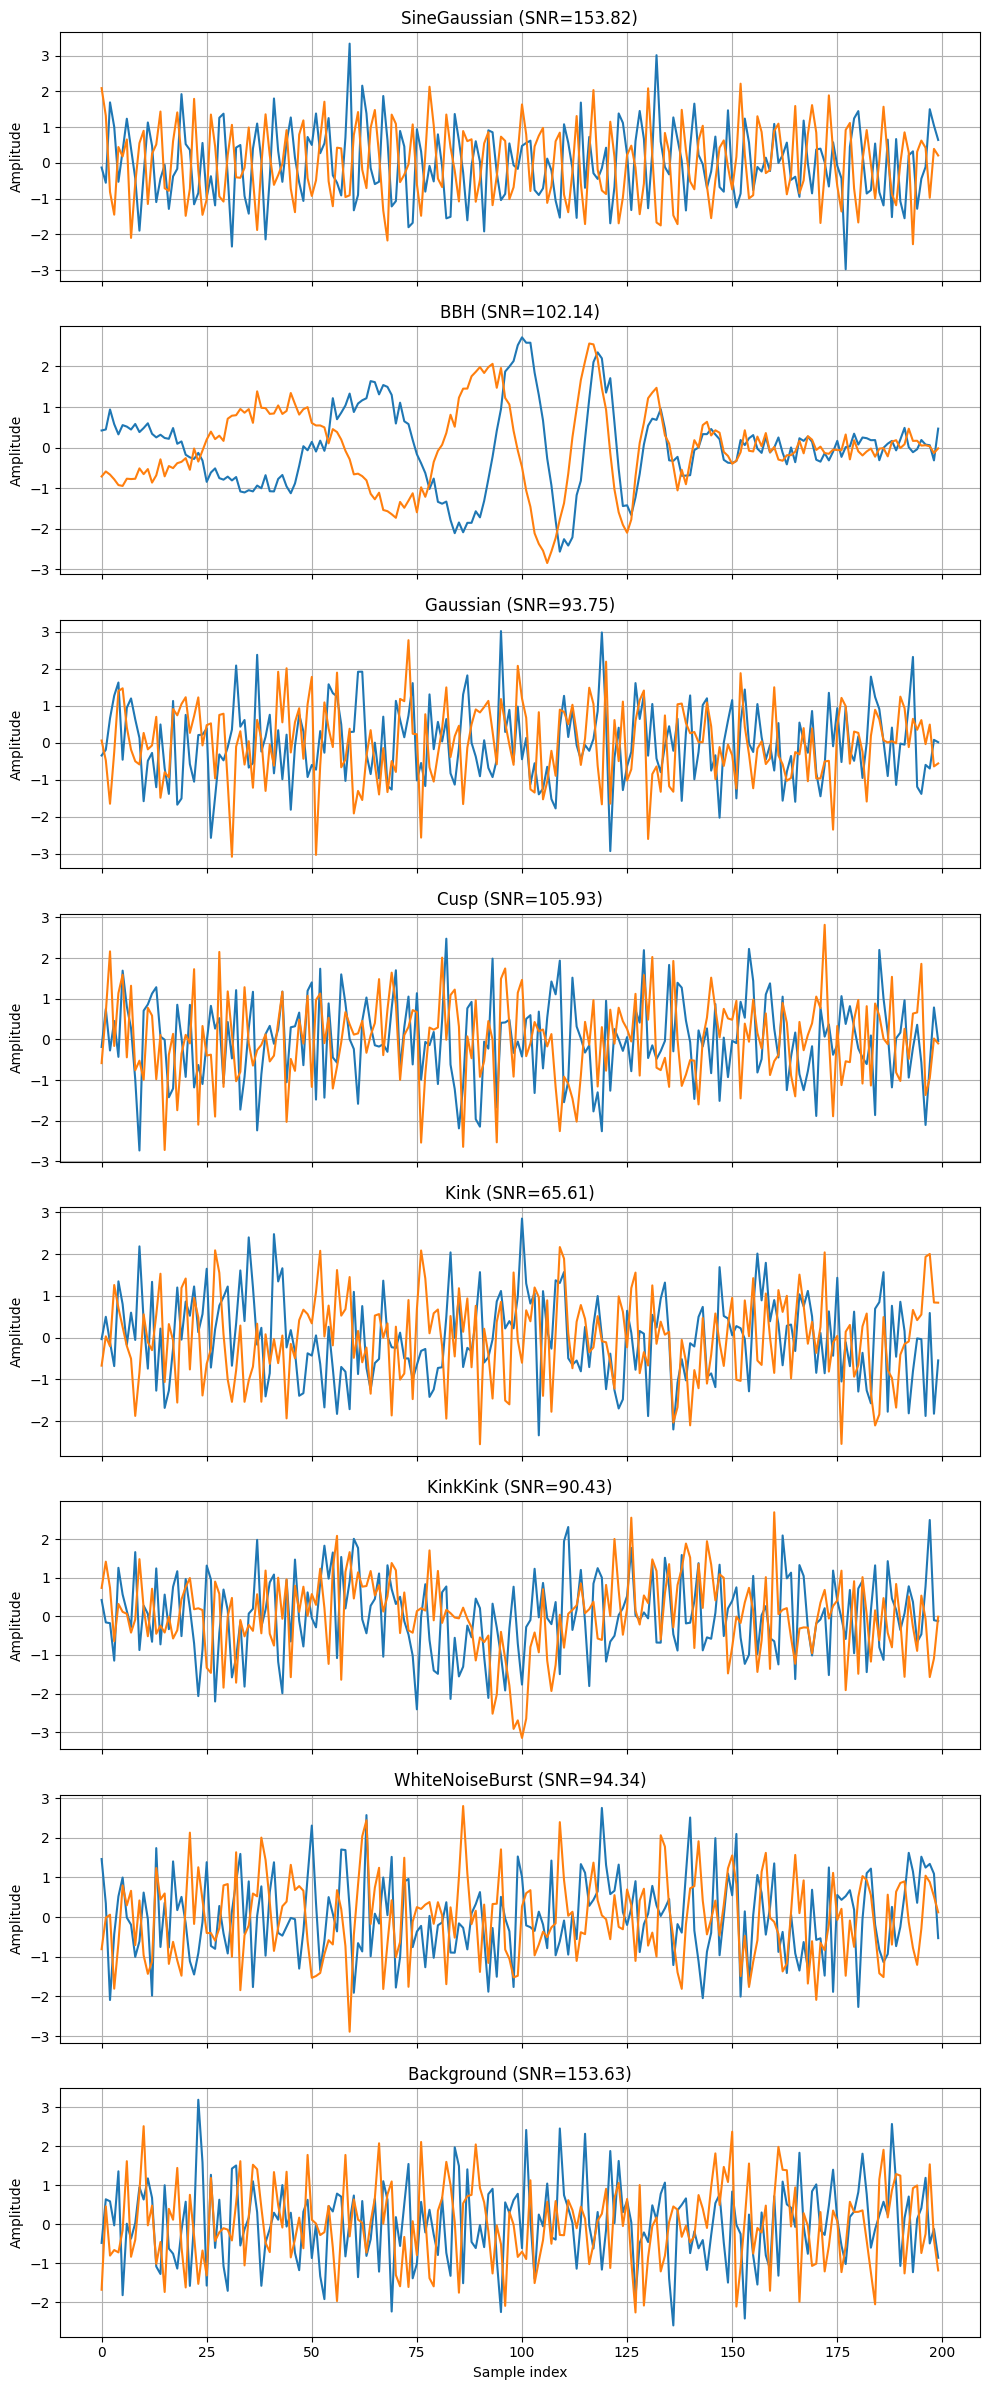

In [7]:
unique_labels = np.unique(all_labels)
n_labels = len(unique_labels)

# Create one subplot per label (stacked vertically)
fig, axes = plt.subplots(n_labels, 1, figsize=(10, 3 * n_labels), sharex=True)

if n_labels == 1:
    axes = [axes]  # Ensure axes is iterable if there's only one label

for i, label in enumerate(unique_labels):
    idx = np.where(all_labels == label)[0][0]  # First example of each class
    waveform = all_x[idx]
    snr_value = all_snr[idx]

    axes[i].plot(waveform[0], label='H1')  # Plot only the first channel
    axes[i].plot(waveform[1], label='L1')  # Plot only the first channel
    axes[i].set_title(f'{signal_classes[label - 1]} (SNR={snr_value:.2f})')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

axes[-1].set_xlabel('Sample index')

plt.tight_layout()
plt.show()